<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: [Available Here](https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv)

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


## Load the data

In [25]:
import pandas as pd

# copied from the markdown link at the top
url = 'https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv'

df = pd.read_csv(url)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
# missing data?
df.isnull().sum().sum()

0

## Clean the data

After exploring the data, I have determined thsee steps:

- Drop 1 column (customerID)
- Treat 13 columns as boolean values
- One-hot-encode 3 columns (into 10 more boolean columns, total)
- Leave 3 as continuous variables

In [3]:
# First, just a bit of exploration

# Several columns have 3 values, the third indicating the customer does not
# have the relevant service
df['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [4]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [5]:
df['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [6]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [27]:
# Some customer do not have a value for total charges
len(df[df['TotalCharges'] == ' '])

11

In [45]:
charges = df[df['TotalCharges'] != ' ']['TotalCharges'].astype(float)
median_charge = charges.median()
median_charge

1397.475

In [0]:
# Define functions used for cleaning
def clean_gender(value):
  """ returns 1 for male, 0 for female """
  return 1 if (value == 'male') else 0

def clean_boolean(value):
  """ returns 0 if value begins with 'No', 1 otherwise """
  return 0 if (value[:2] == 'No') else 1

def clean_charges(value):
  """ changes any occurance of ' ' to the median value """
  return median_charge if (value == ' ') else value

In [8]:
!pip install category_encoders

In [0]:
# using this to return the dataframe
from category_encoders import OneHotEncoder
from sklearn.preprocessing import Normalizer

# Single function that does all steps, could be used on new test data for easy preprocessing
def clean_data(X):
  """ takes a dataframe X, and returns the cleaned version """
  X = X.copy()

  # drop the id column
  X = X.drop('customerID', axis=1)

  # some customers do not have a total charge value, fill with the median
  # (they are also the ones with 0 tenure)
  X['TotalCharges'] = X['TotalCharges'].apply(clean_charges).astype(float)

  # clean the gender column
  X['gender'] = X['gender'].apply(clean_gender)

  # clean boolean columns (note this includes the target)
  columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
             'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
             'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
  for col in columns:
    X[col] = X[col].apply(clean_boolean)

  # one-hot-encode the remaining categorical columns
  encoder = OneHotEncoder()
  X = encoder.fit_transform(X)

  # normalize the continous variables
  norm = Normalizer()
  columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
  for col in columns:
    X[col] = norm.transform([X[col]])[0]

  return X

In [74]:
df_cleaned = clean_data(df)
print(df_cleaned.shape)
df_cleaned.head()

(7043, 27)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0.000293,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0.004981,0.000111,0
1,0,0,0,0,0.009971,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0.009503,0.007002,0
2,0,0,0,0,0.000587,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0.008986,0.000401,1
3,0,0,0,0,0.013197,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0.007058,0.006822,0
4,0,0,0,0,0.000587,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0.011797,0.000562,1


In [76]:
# confirming all data is now numeric
df_cleaned.dtypes

gender                 int64
SeniorCitizen          int64
Partner                int64
Dependents             int64
tenure               float64
PhoneService           int64
MultipleLines          int64
InternetService_1      int64
InternetService_2      int64
InternetService_3      int64
OnlineSecurity         int64
OnlineBackup           int64
DeviceProtection       int64
TechSupport            int64
StreamingTV            int64
StreamingMovies        int64
Contract_1             int64
Contract_2             int64
Contract_3             int64
PaperlessBilling       int64
PaymentMethod_1        int64
PaymentMethod_2        int64
PaymentMethod_3        int64
PaymentMethod_4        int64
MonthlyCharges       float64
TotalCharges         float64
Churn                  int64
dtype: object

In [77]:
# define X and y
X = df_cleaned[df_cleaned.columns[:-1]].values
Y = df_cleaned['Churn'].values

print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (7043, 26)
Y shape: (7043,)


In [91]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, 
                                                    random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (5634, 26)
y_train shape: (5634,)
X_test shape: (1409, 26)
y_test shape: (1409,)


## Create and fit a baseline Keras MLP model to the data

I will also get majority baseline and a RandomForest baseline, for fun

In [92]:
# Majority baseline (just using all data)
true_count = Y.sum()  # works since this is 0 or 1
print("Majority baseline is 0, with frequency", 1 - true_count / len(Y))

Majority baseline is 0, with frequency 0.7346301292063041


In [93]:
# Random Forest baseline
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

print('Random Forest train accuracy:', classifier.score(X_train, y_train))
print('Random Forest test accuracy:', classifier.score(X_test, y_test))

Random Forest train accuracy: 0.9980475683351083
Random Forest test accuracy: 0.7963094393186657


In [113]:
# Keras baseline
from tensorflow.keras import models, layers

model = models.Sequential()

# matching the initial 26 nodes to the 26 features
model.add(layers.Dense(26, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

results = model.fit(X_train, y_train, epochs=100, verbose=0, 
                    validation_data=(X_test, y_test))

print(f"Trained for {len(results.epoch)} epochs")
print(f"Training accuracy: {results.history['acc'][-1]}")
print(f"Test accuracy: {results.history['val_acc'][-1]}")

Trained for 100 epochs
Training accuracy: 0.8365282416343689
Test accuracy: 0.7679204940795898


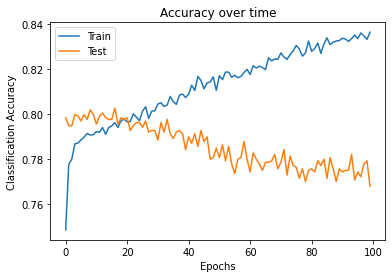

In [114]:
import matplotlib.pyplot as plt

# Graph accuracy over time
epochs = range(len(results.history['acc']))
plt.plot(epochs, results.history['acc'], label='Train')
plt.plot(epochs, results.history['val_acc'], label='Test')

plt.title('Accuracy over time')
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

## Hyperparameter tune (at least) the following parameters:

### batch_size

In [130]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
  model = models.Sequential()
  model.add(layers.Dense(26, activation='relu', input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [8, 16, 32, 64, 128, 256, 512],
              'epochs': [50]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  19 out of  21 | elapsed:  4.6min remaining:   29.1s
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:  4.6min finished


Best: 0.7804401914278666 using {'batch_size': 512, 'epochs': 50}
Means: 0.7703230381011963, Stdev: 0.002795185559720556 with: {'batch_size': 8, 'epochs': 50}
Means: 0.7726304729779562, Stdev: 0.00982810207058179 with: {'batch_size': 16, 'epochs': 50}
Means: 0.7726304531097412, Stdev: 0.0035587413124075202 with: {'batch_size': 32, 'epochs': 50}
Means: 0.7777777711550394, Stdev: 0.005934775056991448 with: {'batch_size': 64, 'epochs': 50}
Means: 0.7776002883911133, Stdev: 0.0032047185013224246 with: {'batch_size': 128, 'epochs': 50}
Means: 0.7793752352396647, Stdev: 0.0021882769463667613 with: {'batch_size': 256, 'epochs': 50}
Means: 0.7804401914278666, Stdev: 0.0028948402275018794 with: {'batch_size': 512, 'epochs': 50}


In [133]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'batch_size': 512, 'epochs': 50}
Test accuracy: 0.7906316518783569


### training epochs

In [134]:
# Testing different training epoch counts

def create_model():
  model = models.Sequential()
  model.add(layers.Dense(26, activation='relu', input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'batch_size': [512],
              'epochs': [10,25,50,75,100,250]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   23.7s remaining:    4.7s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   35.2s finished


Best: 0.7868299682935079 using {'batch_size': 512, 'epochs': 50}
Means: 0.7591409285863241, Stdev: 0.006526383296113926 with: {'batch_size': 512, 'epochs': 10}
Means: 0.7799077232678732, Stdev: 0.0015268614691967583 with: {'batch_size': 512, 'epochs': 25}
Means: 0.7868299682935079, Stdev: 0.003697650980556843 with: {'batch_size': 512, 'epochs': 50}
Means: 0.7825701038042704, Stdev: 0.0029594125562766465 with: {'batch_size': 512, 'epochs': 75}
Means: 0.7813276648521423, Stdev: 0.002795185559720556 with: {'batch_size': 512, 'epochs': 100}
Means: 0.7786652644475301, Stdev: 0.004689324553851143 with: {'batch_size': 512, 'epochs': 250}


In [135]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'batch_size': 512, 'epochs': 50}
Test accuracy: 0.7991483211517334


### optimizer

- learning rate (if applicable to optimizer)
- momentum (if applicable to optimizer)

In [136]:
# Testing different optimizers

def create_model(optimizer='adam'):
  model = models.Sequential()
  model.add(layers.Dense(26, activation='relu', input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'optimizer': ['adam', 'nadam', 'ftrl', 'rmsprop', 'sgd'],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   32.7s remaining:    8.2s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   35.2s finished


Best: 0.7813276449839274 using {'batch_size': 512, 'epochs': 50, 'optimizer': 'rmsprop'}
Means: 0.7811501622200012, Stdev: 0.002300568303633794 with: {'batch_size': 512, 'epochs': 50, 'optimizer': 'adam'}
Means: 0.779730220635732, Stdev: 0.0015268637789398812 with: {'batch_size': 512, 'epochs': 50, 'optimizer': 'nadam'}
Means: 0.7344692945480347, Stdev: 0.007148411463328962 with: {'batch_size': 512, 'epochs': 50, 'optimizer': 'ftrl'}
Means: 0.7813276449839274, Stdev: 0.0006641274847673206 with: {'batch_size': 512, 'epochs': 50, 'optimizer': 'rmsprop'}
Means: 0.7444089452425638, Stdev: 0.01217353621155661 with: {'batch_size': 512, 'epochs': 50, 'optimizer': 'sgd'}


In [137]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'batch_size': 512, 'epochs': 50, 'optimizer': 'rmsprop'}
Test accuracy: 0.8019872307777405


In [140]:
# Testing both learning_rate and momentum in the RMSprop optimizer
from tensorflow.keras.optimizers import RMSprop

def create_model(learn_rate=.001, momentum=0.0):
  model = models.Sequential()
  model.add(layers.Dense(26, activation='relu', input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'learn_rate': [.0001, .001, .01, .1, 1],
    'momentum': [0, .1, .5, .9, 1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  1.9min finished


Best: 0.7841675678888956 using {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.5}
Means: 0.7444089452425638, Stdev: 0.010973089546248739 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.0001, 'momentum': 0}
Means: 0.7548810839653015, Stdev: 0.022144793286547042 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.0001, 'momentum': 0.1}
Means: 0.7768903175989786, Stdev: 0.0030433658027988024 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.0001, 'momentum': 0.5}
Means: 0.7779552737871805, Stdev: 0.0018951090085997649 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.0001, 'momentum': 0.9}
Means: 0.7765353322029114, Stdev: 0.007829871452192605 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.0001, 'momentum': 1}
Means: 0.782037635644277, Stdev: 0.0056575599327741925 with: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0}
Means: 0.777245302995046, Stdev: 0.005241322129174451 with: {'batch_size': 512, 'epochs': 50, 'lea

In [139]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Test accuracy: 0.7984386086463928


### activation functions

https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [147]:
# Testing activation functions

def create_model(learn_rate=.001, momentum=0.0, activation='relu'):
  model = models.Sequential()
  model.add(layers.Dense(26, activation=activation, input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation=activation))
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'activation': ['relu', 'elu', 'sigmoid', 'tanh', 'linear'],
    'learn_rate': [.001],
    'momentum': [.1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   28.9s remaining:    7.2s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   32.7s finished


Best: 0.7843450506528219 using {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.782037635644277, Stdev: 0.0031452145016789158 with: {'activation': 'relu', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7843450506528219, Stdev: 0.0015675865623514661 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7806176940600077, Stdev: 0.003984727738205867 with: {'activation': 'sigmoid', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7843450506528219, Stdev: 0.0011502749546695597 with: {'activation': 'tanh', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.782037635644277, Stdev: 0.0013282549695346414 with: {'activation': 'linear', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}


In [148]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'learn_rate': 0.001, 'momentum': 0.1}
Test accuracy: 0.8019872307777405


### network weight initialization

https://www.tensorflow.org/api_docs/python/tf/keras/initializers

https://keras.io/initializers/

In [149]:
# Testing weight initializers

def create_model(learn_rate=.001, momentum=0.0, 
                 activation='relu', initializer='glorot_uniform'):
  model = models.Sequential()
  model.add(layers.Dense(26, activation=activation, 
                         kernel_initializer=initializer, 
                         input_dim=X_train.shape[1]))
  model.add(layers.Dense(32, activation=activation, 
                         kernel_initializer=initializer))
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'initializer': ['glorot_uniform', 'glorot_normal', 'ones', 'zeros', 
                    'orthogonal', 'random_normal', 'random_uniform'],
    'activation': ['elu'],
    'learn_rate': [.001],
    'momentum': [.1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done  19 out of  21 | elapsed:   27.3s remaining:    2.9s
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   28.7s finished


Best: 0.7850550214449564 using {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7793752352396647, Stdev: 0.0013282337293920915 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'glorot_uniform', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7823926210403442, Stdev: 0.0013975738554264303 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'glorot_normal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.5536031325658163, Stdev: 0.20516425351007267 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'ones', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7344692945480347, Stdev: 0.007148411463328962 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'zeros', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7850550214449564, Stdev: 0.0032920269863839675 with: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, '

In [150]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'activation': 'elu', 'batch_size': 512, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Test accuracy: 0.8041163682937622


### dropout regularization

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [152]:
# Testing dropout

def create_model(learn_rate=.001, momentum=0.0, 
                 activation='relu', initializer='glorot_uniform',
                 dropout=0):
  model = models.Sequential()
  model.add(layers.Dense(26, activation=activation, 
                         kernel_initializer=initializer, 
                         input_dim=X_train.shape[1]))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(32, activation=activation, 
                         kernel_initializer=initializer))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'dropout': [0, .1, .2, .3, .4, .5],
    'initializer': ['orthogonal'],
    'activation': ['elu'],
    'learn_rate': [.001],
    'momentum': [.1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   35.8s remaining:    7.2s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   39.3s finished


Best: 0.7871849735577902 using {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7871849735577902, Stdev: 0.0010040503231255249 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7822151382764181, Stdev: 0.00428199092185191 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0.1, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7823926210403442, Stdev: 0.004689352378697115 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0.2, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7838125824928284, Stdev: 0.002644601640768048 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0.3, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Means: 0.7829250892003378, Stdev: 0.001

In [153]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1}
Test accuracy: 0.8062455654144287


### number of neurons in the hidden layer

In [155]:
# Testing number of neurons

def create_model(learn_rate=.001, momentum=0.0, 
                 activation='relu', initializer='glorot_uniform',
                 dropout=0, n_nodes=32):
  model = models.Sequential()
  model.add(layers.Dense(26, activation=activation, 
                         kernel_initializer=initializer, 
                         input_dim=X_train.shape[1]))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(n_nodes, activation=activation, 
                         kernel_initializer=initializer))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'n_nodes': [8, 16, 24, 32, 50, 100],
    'dropout': [0],
    'initializer': ['orthogonal'],
    'activation': ['elu'],
    'learn_rate': [.001],
    'momentum': [.1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   23.5s remaining:    4.7s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   26.6s finished


Best: 0.7854100068410238 using {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_nodes': 24}
Means: 0.7848775386810303, Stdev: 0.001150302546319925 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_nodes': 8}
Means: 0.7804401914278666, Stdev: 0.0027951578037931327 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_nodes': 16}
Means: 0.7854100068410238, Stdev: 0.0008695574201125026 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_nodes': 24}
Means: 0.782037615776062, Stdev: 0.002547513306666591 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'm

In [156]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_nodes': 24}
Test accuracy: 0.8012775182723999


### Number of hidden layers

In [159]:
# Testing number of neurons

def create_model(learn_rate=.001, momentum=0.0, 
                 activation='relu', initializer='glorot_uniform',
                 dropout=0, n_nodes=32, n_layers=1):
  model = models.Sequential()

  # input layer
  model.add(layers.Dense(26, activation=activation, 
                         kernel_initializer=initializer, 
                         input_dim=X_train.shape[1]))
  model.add(layers.Dropout(dropout))

  # add n_layers hidden layers
  for _ in range(n_layers):
    model.add(layers.Dense(n_nodes, activation=activation, 
                          kernel_initializer=initializer))
    model.add(layers.Dropout(dropout))

  # output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  rms = RMSprop(learning_rate=learn_rate, momentum=momentum)
  model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {
    'n_layers': [0, 1, 2, 3, 4, 5],
    'n_nodes': [24],
    'dropout': [0],
    'initializer': ['orthogonal'],
    'activation': ['elu'],
    'learn_rate': [.001],
    'momentum': [.1],
    'batch_size': [512],
    'epochs': [50]
    }

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, 
                    n_jobs=4, verbose=5)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   26.4s remaining:    5.3s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   30.2s finished


Best: 0.7843450506528219 using {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_layers': 1, 'n_nodes': 24}
Means: 0.7806176741917928, Stdev: 0.0033956695249937473 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_layers': 0, 'n_nodes': 24}
Means: 0.7843450506528219, Stdev: 0.002644589639551476 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_layers': 1, 'n_nodes': 24}
Means: 0.7834575772285461, Stdev: 0.004789039853552183 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_layers': 2, 'n_nodes': 24}
Means: 0.7770678003629049, Stdev: 0.007496882352993639 with: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epoc

In [160]:
# Current test accuracy
print('Best params:', grid.best_params_)
print('Test accuracy:', grid.score(X_test, y_test))

Best params: {'activation': 'elu', 'batch_size': 512, 'dropout': 0, 'epochs': 50, 'initializer': 'orthogonal', 'learn_rate': 0.001, 'momentum': 0.1, 'n_layers': 1, 'n_nodes': 24}
Test accuracy: 0.7991483211517334


## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?

### Try to implement Random Search Hyperparameter Tuning on this dataset

If I put together all of the different parameters I tried here, there are: `7 * 6 * 5 * 5 * 5 * 5 * 7 * 6 * 6 * 6 = 39,690,000` combinations.

Why not try random search on them all?

